<a href="https://colab.research.google.com/github/SofiyaHevorhyan/AIProject_FraudDetection/blob/master/AI_project_Hevorhyan_Zubyk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


## User Guide

This notebook is a part of project on the Artificial Intelligence course and represents a work which goal is to detect fraud users among normal ones. The data belongs to sales industry and has such information as products bought, amount spend, etc.
<br>
This code can also be divided into two parts. Preprocessing, feature generation and all training steps are the first one and can not be reproduced due to the terms of NDA. The second one - the testing part- has all files and model needed.

## Data description

 - **TRN_ID** - id of a single transaction
 - **TRN_WALLET_WAL** and **TRN_WAL_PERSON_ID** - unique keys that identify a single user
 - **PLC_CODE** - the code of the place where transaction occurs
 - **F_CARD** - the unique id of the store's card
 - **DAT / F_TRN_DATE** - the date when transaction occurs
 - **POINTS_NARAH** - the amount of points that was earned during transaction
 - **POINTS_SPYS** - the amount of points that was discarded as a discount during transaction
 - **BKT_PRD_CODE** (basket product code) - the code of the product bought
 - **BKT_QUANTITY**	(basket quantity) - the quantity of the product bought
 - **BKT_AMOUNT_GROSS** - money paid for the product
 - **BKT_DSC_GROSS** - discount that was given for this product
 - **MOP_TYPE** - type of payment - card, application or cash

## Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 200)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

-------------------------------------------------------------- NOT REPRODUCIBLE PART --------------------------------------------------------------

## Load data

In [0]:
PATH = "./drive/My Drive/AI_Project_Data/"

# data with all transactions (except caught frauds)
transaction = pd.read_csv(PATH + "data/NewData/transaction2.csv", encoding="cp1251", sep=";", quotechar="\x07")
# data with all products bought during those transactions
basket = pd.read_csv(PATH + "data/NewData/basket.csv", encoding="cp1251", sep=";", quotechar="\x07")

normal = pd.merge(transaction, basket, how='left', on = 'TRN_ID')

In [0]:
# data with transactions and products of caught frauds
frauds = pd.read_csv(PATH + "Labeled_fraud/fraud_data.csv")

# data about those frauds whose behavior is relabeled as 1 such truly
# recognised fraud actions and 0 as normal ones which won't confuse our model
# in the future
fraud_id = pd.read_excel(PATH + "Labeled_fraud/fraud_11_07.xlsx")

In [0]:
normal = normal[normal.PAR_NAME == PARTNER]
frauds = frauds[frauds.PAR_NAME == PARTNER]
normal.drop(["PAR_NAME", "PLC_NAME"], axis = 1, inplace = True)

In [0]:
frauds.drop(["PAR_NAME","PLC_NAME"], axis = 1, inplace = True)
fraud_id.drop(["PAR_NAME","PLC_NAME"], axis = 1, inplace = True)

In [0]:
# drop some features from view due to security
DROP = ["PRD_NAME"]

normal.drop(DROP, axis=1).head()

,TRN_ID,PLC_CODE,TRN_WAL_WALLET,TRN_WAL_PERSON_ID,F_CARD,DAT,POINTS_NARAH,POINTS_SPYS,BKT_PRD_CODE,BKT_QUANTITY,BKT_AMOUNT_GROSS,BKT_DSC_GROSS,MOP_TYPE
0,5bd7109be4b0912cbae1ee4e,41062100,59834ec5e4b0f8336582f791,13491531,6ddded186c56e687394dcba181038da7,29.10.2018 15:52:25,"0,03",NaN,9439,"11,99","187,4","12,71",C
1,5ba8a750e4b0b5e360251b4e,40110200,589c933ae4b0300f9f47da44,1084700,b0b3c279a6280d2760f68fe016c07d2b,24.09.2018 11:58:55,"5,78",NaN,9439,"19,25","300,11",0,C
2,5cacf13de4b0cfb31b3f4702,41262500,589c9719e4b0300f9fa9e06a,2326758,251ea8bc807a1f70f6a322f6e160e996,09.04.2019 22:23:41,10,"-54,25",9439,25,283,"54,25",D
3,5a70b757e4b005c87589189e,21160900,589c96ebe4b0300f9fa4621e,1992820,21dfe83602f30cb18912442f7ff06277,30.01.2018 20:20:08,"3,3",NaN,9009,10,"329,9",0,C
4,5b8369ade4b05660e070eddc,40213800,589c9761e4b0300f9fb1ccbe,8833892,613a6f810f30d05ddcd0af953441292c,27.08.2018 06:02:04,NaN,NaN,69620,1,"12,8","3,2",C


In [0]:
frauds.drop(DROP, axis=1).head()

,Unnamed: 0,UNIQUE_ID,TRN_WAL_WALLET,TRN_WAL_PERSON_ID,TRN_ID,PLC_CODE,F_CARD,F_TRN_DATE,POINTS_NARAH,POINTS_SPYS,BKT_PRD_CODE,BKT_QUANTITY,BKT_AMOUNT_GROSS,BKT_DSC_GROSS,Fraud,payment_type,F_TRN_DATE_DAY,F_TRN_DATE_TIME
0,385463,4067,589c926ce4b0300f9f225171,3963564,58a7a271e4b08c724fbc24df,40163500,d4e8d3c9bcecd82d54809b0ea7f44509,2017-01-04 12:12:00,4.14,0.0,NaN,0.0,0.0,0.0,1,Card,2017-01-04,12:12:00
1,385464,4067,589c926ce4b0300f9f225171,3963564,58a7a38fe4b08c724fe1e10d,40163500,d4e8d3c9bcecd82d54809b0ea7f44509,2017-01-09 01:45:00,3.60,0.0,NaN,0.0,0.0,0.0,1,Card,2017-01-09,01:45:00
2,385465,4067,589c926ce4b0300f9f225171,3963564,58a7a918e4b08c725019e451,40163500,d4e8d3c9bcecd82d54809b0ea7f44509,2017-01-16 10:22:00,3.36,0.0,NaN,0.0,0.0,0.0,1,Card,2017-01-16,10:22:00
3,385466,4067,589c926ce4b0300f9f225171,3963564,58a7a9dee4b08c7250205fd6,40163500,d4e8d3c9bcecd82d54809b0ea7f44509,2017-01-17 07:58:00,1.39,0.0,NaN,0.0,0.0,0.0,1,Card,2017-01-17,07:58:00
4,385467,4067,589c926ce4b0300f9f225171,3963564,58a7adc2e4b08c7250428e43,40163500,d4e8d3c9bcecd82d54809b0ea7f44509,2017-01-21 08:03:00,2.37,0.0,NaN,0.0,0.0,0.0,1,Card,2017-01-21,08:03:00


In [0]:
fraud_id.drop(DROP, axis=1).head()

,TRN_WAL_WALLET,TRN_WAL_PERSON_ID,F_TRN_DATE,TRN_ID,POINTS_NARAH,POINTS_SPYS,BKT_QUANTITY,Label,Label_new
0,32390,1043605,2017-06-24 16:26:00,594e66dde4b010eb33233daa,4.64,0.0,20.00,0,0
1,1138766,1043605,2017-06-24 16:26:00,594e66f4e4b010eb33233e3b,0.60,0.0,1.00,0,0
2,2295581,1043605,2017-07-05 22:25:00,595d3d82e4b069a53b9c2479,9.65,0.0,35.16,0,0
3,2295582,1043605,2017-07-05 22:25:00,595d3d82e4b069a53b9c2479,9.65,0.0,1.00,0,0
4,3344442,1043605,2017-07-09 09:32:00,5961ce5fe4b069a53bab4053,1.52,0.0,1.00,0,0


In [0]:
# more than 7 000 000 transactions
print(normal.shape)
print(frauds.shape)
print(fraud_id.shape)

(7959202, 14)
(8385, 19)
(12563, 10)


In [0]:
normal.dtypes

TRN_ID               object
PLC_CODE             object
TRN_WAL_WALLET       object
TRN_WAL_PERSON_ID     int64
F_CARD               object
DAT                  object
POINTS_NARAH         object
POINTS_SPYS          object
BKT_PRD_CODE         object
PRD_NAME             object
BKT_QUANTITY         object
BKT_AMOUNT_GROSS     object
BKT_DSC_GROSS        object
MOP_TYPE             object
dtype: object

In [0]:
# there are no fraud transactions in the normal dataset
np.intersect1d(normal["TRN_ID"] , frauds['TRN_ID']) 

array([], dtype=object)

# Preprocessing

In [0]:
def preprocessing(df, normal = False, fraud = False):
  """
  Does all the preprocessing in one go. Can be used for both fraud and full dataset
  """
  if normal:
    print('Processing non-fraud users...')
    df['Fraud'] = 0
    date_format = '%d.%m.%Y %H:%M:%S'

    #transform to the same format as in frauds
    df['payment_type'] = df.MOP_TYPE.apply(lambda x: 'App' if x == 'M' else 'Cash' if x == 'C' else 'Card')
    df = df.rename(columns = {'DAT':"F_TRN_DATE"})
    df.drop(['MOP_TYPE'], axis=1, inplace=True)
    print(df.columns)

  if fraud:
    print("Processing fraud users...")
    date_format = '%Y-%m-%d %H:%M:%S'
    day_format = '%Y-%m-%d'
    df.drop(["Unnamed: 0", "UNIQUE_ID"], inplace=True, axis=1)
    
  # split transaction time into date and time
  print('Transform the date into pandas datetime')
  df['F_TRN_DATE'] = df['F_TRN_DATE'].apply(pd.to_datetime, format = date_format)
  print('Extract date')
  df['F_TRN_DATE_DAY'] = df['F_TRN_DATE'].dt.date
  df['F_TRN_DATE_DAY'] = pd.to_datetime(df['F_TRN_DATE_DAY'])
  print('Extract time')
  df['F_TRN_DATE_TIME'] = df['F_TRN_DATE'].dt.time
  df.drop("F_TRN_DATE", inplace=True, axis=1)

  # Transform numeric values to floats
  df[["BKT_QUANTITY", "BKT_AMOUNT_GROSS", "BKT_DSC_GROSS", "POINTS_NARAH", "POINTS_SPYS"]] = \
  df[["BKT_QUANTITY", "BKT_AMOUNT_GROSS", "BKT_DSC_GROSS", "POINTS_NARAH", "POINTS_SPYS"]].\
  apply(lambda x: x.fillna(0)) 

  print(df.dtypes)
  return df


## Normal



In [0]:
normal = preprocessing(normal, normal = True)

# This might take a while, go get some tea!

Processing non-fraud users...
Index(['TRN_ID', 'PLC_CODE', 'TRN_WAL_WALLET', 'TRN_WAL_PERSON_ID', 'F_CARD',
       'F_TRN_DATE', 'POINTS_NARAH', 'POINTS_SPYS', 'BKT_PRD_CODE', 'PRD_NAME',
       'BKT_QUANTITY', 'BKT_AMOUNT_GROSS', 'BKT_DSC_GROSS', 'Fraud',
       'payment_type'],
      dtype='object')
Transform the date into pandas datetime
Extract date
Extract time
TRN_ID                       object
PLC_CODE                     object
TRN_WAL_WALLET               object
TRN_WAL_PERSON_ID             int64
F_CARD                       object
POINTS_NARAH                 object
POINTS_SPYS                  object
BKT_PRD_CODE                 object
PRD_NAME                     object
BKT_QUANTITY                 object
BKT_AMOUNT_GROSS             object
BKT_DSC_GROSS                object
Fraud                         int64
payment_type                 object
F_TRN_DATE_DAY       datetime64[ns]
F_TRN_DATE_TIME              object
dtype: object


## Frauds

In [0]:
frauds = preprocessing(frauds, fraud=True)

Processing fraud users...
Transform the date into pandas datetime
Extract date
Extract time
TRN_WAL_WALLET               object
TRN_WAL_PERSON_ID             int64
TRN_ID                       object
PLC_CODE                     object
F_CARD                       object
POINTS_NARAH                float64
POINTS_SPYS                 float64
BKT_PRD_CODE                 object
PRD_NAME                     object
BKT_QUANTITY                float64
BKT_AMOUNT_GROSS            float64
BKT_DSC_GROSS               float64
Fraud                         int64
payment_type                 object
F_TRN_DATE_DAY       datetime64[ns]
F_TRN_DATE_TIME              object
dtype: object


In [0]:
# 69 unique users that were caught
frauds.groupby(["TRN_WAL_PERSON_ID", "TRN_WAL_WALLET"]).nunique().shape

(69, 16)

In [0]:
frauds['F_TRN_DATE_TIME'] = pd.to_datetime(frauds['F_TRN_DATE_TIME'],format= '%H:%M:%S').dt.time

In [0]:
# there are 69 unique frauds that were caught during this time
frauds.TRN_WAL_PERSON_ID.nunique()

69

In [0]:
# extract those frauds from fraud_id dataframe whose behavior were labeled 
# as really suspiciously fraud one 
# there are 70 such users
labeled_true_frauds = fraud_id.TRN_WAL_PERSON_ID[fraud_id.Label_new==1].unique()
labeled_true_frauds.shape

(70,)

In [0]:
# check that each of the frauds in frauds df has behaviour labaled as 
# fraud behaviour (Label_new == 1) in fraud_id df
set(frauds.TRN_WAL_PERSON_ID.unique()).difference(set(labeled_true_frauds))

set()

## Merged

In [0]:
normal.shape

(7959202, 16)

In [0]:
frauds.shape

(8385, 16)

In [0]:
# timerange of transactions of non-fraud users
print(max(normal.F_TRN_DATE_DAY))
print(min(normal.F_TRN_DATE_DAY))

2019-09-19 00:00:00
2017-01-01 00:00:00


In [0]:
# timerange of transactions of labeled fraud users
print(max(frauds.F_TRN_DATE_DAY))
print(min(frauds.F_TRN_DATE_DAY))

2017-12-30 00:00:00
2017-01-01 00:00:00


We have data for frauds and their operations ony for the year 2017, so all the operations of "normal" users we will analyze will be those of 2017. Also, to handle class imbalance, we will take only the last 3 months of transactions for every non-fraud user.

For example, if user 1 was active until end of April 2017, and user 2 - until end of December 2017, we will use user's 1 transactions for February till April, and user's 2 - from October till December.

In [0]:
# all transaction in 2017
normal = normal[(normal.F_TRN_DATE_DAY > min(frauds.F_TRN_DATE_DAY))&(normal.F_TRN_DATE_DAY < max(frauds.F_TRN_DATE_DAY))]
normal.shape

(1961276, 16)

In [0]:
# more than 21 000 unique users in 2017
normal.groupby(['TRN_WAL_PERSON_ID', 'TRN_WAL_WALLET']).nunique().shape

(21442, 16)

In [0]:
def interval_of_transactions(data, lag=90):
    '''
    chooses only transactions during last n active days of each user
    '''
    last_trans = data.groupby(["TRN_WAL_PERSON_ID", "TRN_WAL_WALLET"])["F_TRN_DATE_DAY"].max().rename("last_trans")
    data = data.merge(last_trans, how = "left", on = ["TRN_WAL_PERSON_ID","TRN_WAL_WALLET"])
    data['lag'] =(data['last_trans'] - data['F_TRN_DATE_DAY'])
    data_subset = data[data['lag'] < timedelta(days=lag)].reset_index(drop=True)
    data_subset.drop(['lag','last_trans'], inplace = True, axis=1)
    return data_subset

In [0]:
normal = interval_of_transactions(normal)

In [0]:
# number of transactions in 2017 only last 3 months
normal.shape

(627703, 16)

In [0]:
normal.groupby(['TRN_WAL_WALLET', 'TRN_WAL_PERSON_ID']).nunique().shape

(21442, 16)

So, we have only 21 442 unique users that were active in 2017, and 627 703 transactions of these users but only capturing last three months for them

In [0]:
normal.drop(DROP, axis=1).head()

,TRN_ID,PLC_CODE,TRN_WAL_WALLET,TRN_WAL_PERSON_ID,F_CARD,POINTS_NARAH,POINTS_SPYS,BKT_PRD_CODE,BKT_QUANTITY,BKT_AMOUNT_GROSS,BKT_DSC_GROSS,Fraud,payment_type,F_TRN_DATE_DAY,F_TRN_DATE_TIME
0,59d3cdefe4b0c6012ffbabbf,40914000,589c9198e4b0300f9ef18920,168062,5517402eed6bef6a67e8d61cc67c9d8f,"20,1",0,9439,"40,15","533,59",0,0,Card,2017-10-03,20:51:04
1,59b982f1e4b043aa0e9ba7fd,40111000,589c91d2e4b0300f9f00209a,302356,2b2f4c468da888d594683dc7ddeeb251,"0,25",0,61211,1,"0,25",0,0,Cash,2017-09-13,22:11:42
2,59ff150fe4b0079b0fbad26c,60160400,589ca0aee4b0300fa0620734,12768714,45ade3aac24f8e900445ad1d31a5bb80,"0,17",0,61203,1,"0,17",0,0,Cash,2017-11-05,15:42:53
3,5a1eb4ffe4b0cb38088891d1,46061000,589ca051e4b0300fa05bebcb,12560237,b20ac874c35a821188be81e6e45e32cc,"0,2",0,61206,1,"0,2",0,0,Cash,2017-11-29,15:21:01
4,5a360f9ae4b0c5165c82bd2b,40211300,589c9185e4b0300f9eed844a,106318,7080a947b24e768b0d2cd1288a13a93b,"13,65",0,9018,"10,92","300,19",0,0,Cash,2017-12-17,08:34:53


In [0]:
frauds = interval_of_transactions(frauds)

In [0]:
frauds.shape

(4725, 16)

In [0]:
frauds.groupby(['TRN_WAL_WALLET', 'TRN_WAL_PERSON_ID']).nunique().shape

(69, 16)

In [0]:
# merge
data = pd.concat([normal, frauds]).reset_index(drop=True)
data.shape
data.drop(DROP, axis=1).head()

(632428, 16)

,BKT_AMOUNT_GROSS,BKT_DSC_GROSS,BKT_PRD_CODE,BKT_QUANTITY,F_CARD,F_TRN_DATE_DAY,F_TRN_DATE_TIME,Fraud,PLC_CODE,POINTS_NARAH,POINTS_SPYS,TRN_ID,TRN_WAL_PERSON_ID,TRN_WAL_WALLET,payment_type
0,"533,59",0,9439,"40,15",5517402eed6bef6a67e8d61cc67c9d8f,2017-10-03,20:51:04,0,40914000,"20,1",0,59d3cdefe4b0c6012ffbabbf,168062,589c9198e4b0300f9ef18920,Card
1,"0,25",0,61211,1,2b2f4c468da888d594683dc7ddeeb251,2017-09-13,22:11:42,0,40111000,"0,25",0,59b982f1e4b043aa0e9ba7fd,302356,589c91d2e4b0300f9f00209a,Cash
2,"0,17",0,61203,1,45ade3aac24f8e900445ad1d31a5bb80,2017-11-05,15:42:53,0,60160400,"0,17",0,59ff150fe4b0079b0fbad26c,12768714,589ca0aee4b0300fa0620734,Cash
3,"0,2",0,61206,1,b20ac874c35a821188be81e6e45e32cc,2017-11-29,15:21:01,0,46061000,"0,2",0,5a1eb4ffe4b0cb38088891d1,12560237,589ca051e4b0300fa05bebcb,Cash
4,"300,19",0,9018,"10,92",7080a947b24e768b0d2cd1288a13a93b,2017-12-17,08:34:53,0,40211300,"13,65",0,5a360f9ae4b0c5165c82bd2b,106318,589c9185e4b0300f9eed844a,Cash


## Preparation

In [0]:
#Last check if there are any NA's
#that may hinder our correct feature generation.
data.isna().sum()

BKT_AMOUNT_GROSS        0
BKT_DSC_GROSS           0
BKT_PRD_CODE         4337
BKT_QUANTITY            0
F_CARD                  0
F_TRN_DATE_DAY          0
F_TRN_DATE_TIME         0
Fraud                   0
PLC_CODE                0
POINTS_NARAH            0
POINTS_SPYS             0
PRD_NAME             4337
TRN_ID                  0
TRN_WAL_PERSON_ID       0
TRN_WAL_WALLET          0
payment_type            0
dtype: int64

Information for some products was missing from the start, so it is OK. We're all set!

In [0]:
data.PRD_NAME  = data.PRD_NAME.astype(str)

# Feature Generation

### Current filters made by station agents
* Were active in previous 2 months
* Had petrol transactions
* Purchased petrol 95% on one station
* Had at least once 3+ petrol transactions, one day, one place

Read more on this in the report.

In [0]:
def feature_generation(data):
    """
    Generate features for all our users using all their transactions
    """
    # gas transactions during last 2 months
    petrol = ['9018', '9009', '9007', '22242', '9012', '9439', '45290']
    data_petrol = data[data.BKT_PRD_CODE.isin(petrol)]
    
    # ids with wallet, person for all users during specified period
    # to add features based on gas/cigarettes/etc.
    d_base = data[['TRN_WAL_WALLET','TRN_WAL_PERSON_ID', 'Fraud']].drop_duplicates()
    
    # t1 - Number of active days with gas trns on stations during last 3 months
    t1 = data_petrol.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).F_TRN_DATE_DAY.nunique().\
    reset_index().rename(columns = {'F_TRN_DATE_DAY':'n_active_petrol_days'})
    d = pd.merge(d_base, t1, how = 'left')
    
    # t11 - Number of active days with all products (inlcuding gas) on petrol stations during last 3 months
    t11 = data.groupby(['TRN_WAL_WALLET', 'TRN_WAL_PERSON_ID']).F_TRN_DATE_DAY.nunique().\
    reset_index().rename(columns = {'F_TRN_DATE_DAY':'n_active_days'})
    d11 = pd.merge(d, t11, how = 'left')
    
    # Number of gas transactions
    t21 = data_petrol.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).TRN_ID.nunique().reset_index().\
    rename(columns = {'TRN_ID':'n_petrol_trns'})
    d12 = pd.merge(d11, t21, how = 'left')

    # Number of all transactions
    t2 = data.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).TRN_ID.nunique().reset_index().\
    rename(columns = {'TRN_ID':'n_all_trns'})
    d2 = pd.merge(d12, t2, how = 'left')
    
    # main petrol station
    d_partner = data.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID','PLC_CODE']).TRN_ID.nunique().reset_index().\
    rename(columns={'TRN_ID':'n_TRNs','PLC_CODE':'main_petrol_st'})

    d_main = d_partner.copy()
    d_main['max_n_trns_one_st'] = d_main.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).n_TRNs.transform(max)

    # t4 - main petrol station per user (with max number of trns)
    idx = d_main.n_TRNs == d_main.max_n_trns_one_st
    t4 = d_main[idx].groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).first().reset_index()
    d4 = pd.merge(d2, t4.drop('n_TRNs', axis=1), how = 'left')
    d4['ratio_trns_main_st'] = 1.0*d4.max_n_trns_one_st/d4.n_all_trns
        
    # transactions on main petrol station
    # main station by user
    t41 = pd.merge(data, t4[['TRN_WAL_WALLET','TRN_WAL_PERSON_ID','main_petrol_st']], how = 'inner', 
               left_on = ['TRN_WAL_WALLET','TRN_WAL_PERSON_ID','PLC_CODE'], 
               right_on = ['TRN_WAL_WALLET','TRN_WAL_PERSON_ID','main_petrol_st'])
    # number of gas purchases in one day on main petrol station
    t5 = t41[t41.BKT_PRD_CODE.isin(petrol)].groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID','F_TRN_DATE_DAY']).\
    TRN_ID.nunique().reset_index().rename(columns={'TRN_ID':'n_gas_TRNs_per_day'})

    ## t5 - N gas purchases one day main petrol station
    t51 = t5.groupby(['TRN_WAL_PERSON_ID', 'TRN_WAL_WALLET', 'n_gas_TRNs_per_day']).F_TRN_DATE_DAY.\
    nunique().reset_index().rename(columns={'F_TRN_DATE_DAY':'n_of_days_when_typical_n_of_gas_TRNs',
                                          'n_gas_TRNs_per_day':'typical_n_of_gas_TRNs_on_main_st'})
    indx = (t51.n_of_days_when_typical_n_of_gas_TRNs == t51.groupby(['TRN_WAL_PERSON_ID','TRN_WAL_WALLET']).\
          n_of_days_when_typical_n_of_gas_TRNs.transform(max))
    t52 = t51[indx].groupby(['TRN_WAL_PERSON_ID']).first().reset_index()
    
    d5 = pd.merge(d4, t52, how = 'left')
  
    # Number of days with 3+ gas transactions
    t6 = t5[t5.n_gas_TRNs_per_day >= 3].groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).F_TRN_DATE_DAY.nunique().\
    reset_index().rename(columns = {'F_TRN_DATE_DAY' : 'n_days_with_3+_gas_trns_main_st'})
    d6 = pd.merge(d5, t6, how = 'left')

    #Maximum number of different gas types purchased on main station
    t7 = t41[t41.BKT_PRD_CODE.isin(petrol)].groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).BKT_PRD_CODE.\
    nunique().reset_index().rename(columns = {'BKT_PRD_CODE':'max_petrol_types_main_st'})
    d7 = pd.merge(d6, t7, how = 'left')
    
    d7["pct_petrol_days"] = d7.n_active_petrol_days / d7.n_active_days
    d7["n_gas_TRNs_per_day"] = d7.n_petrol_trns / d7.n_active_days

    #Cigarette transactions
    t8 = t41[t41.PRD_NAME.str.startswith("Сигарети")]
    t8['CIG_BRAND'] = t8.PRD_NAME.apply(lambda x: ' '.join(str(x).split(' ')[:3]))
    
    #Maximum number of different cigarette brands on all stations
    t9 = t8.groupby(['TRN_WAL_WALLET','TRN_WAL_PERSON_ID']).CIG_BRAND.\
    nunique().reset_index().rename(columns = {'CIG_BRAND':'max_cigar_brand'})
    d8 = pd.merge(d7, t9, how = 'left',on =['TRN_WAL_PERSON_ID',"TRN_WAL_WALLET"])
    
    d8.fillna(0, inplace=True)
    return d8

In [0]:
data.shape

(632428, 16)

In [0]:
data_features = feature_generation(data)

In [0]:
data_features.head()

,TRN_WAL_WALLET,TRN_WAL_PERSON_ID,Fraud,n_active_petrol_days,n_active_days,n_petrol_trns,n_all_trns,main_petrol_st,max_n_trns_one_st,ratio_trns_main_st,typical_n_of_gas_TRNs_on_main_st,n_of_days_when_typical_n_of_gas_TRNs,n_days_with_3+_gas_trns_main_st,max_petrol_types_main_st,pct_petrol_days,n_gas_TRNs_per_day,max_cigar_brand
0,589c9198e4b0300f9ef18920,168062,0,14.0,14,17.0,22,40914000,11,0.500000,1.0,6.0,0.0,3.0,1.000000,1.214286,0.0
1,589c91d2e4b0300f9f00209a,302356,0,14.0,18,17.0,24,40111000,4,0.166667,1.0,1.0,0.0,1.0,0.777778,0.944444,0.0
2,589ca0aee4b0300fa0620734,12768714,0,2.0,2,3.0,4,60160400,2,0.500000,1.0,1.0,0.0,1.0,1.000000,1.500000,0.0
3,589ca051e4b0300fa05bebcb,12560237,0,23.0,23,24.0,37,46061000,36,0.972973,1.0,21.0,0.0,2.0,1.000000,1.043478,0.0
4,589c9185e4b0300f9eed844a,106318,0,38.0,41,43.0,50,40211300,28,0.560000,1.0,24.0,0.0,1.0,0.926829,1.048780,0.0


In [0]:
data_features.isna().sum()

TRN_WAL_WALLET                          0
TRN_WAL_PERSON_ID                       0
Fraud                                   0
n_active_petrol_days                    0
n_active_days                           0
n_petrol_trns                           0
n_all_trns                              0
main_petrol_st                          0
max_n_trns_one_st                       0
ratio_trns_main_st                      0
typical_n_of_gas_TRNs_on_main_st        0
n_of_days_when_typical_n_of_gas_TRNs    0
n_days_with_3+_gas_trns_main_st         0
max_petrol_types_main_st                0
pct_petrol_days                         0
n_gas_TRNs_per_day                      0
max_cigar_brand                         0
dtype: int64

In [0]:
data_features.shape

(21511, 17)

In [0]:
data_features.dtypes

TRN_WAL_WALLET                           object
TRN_WAL_PERSON_ID                         int64
Fraud                                     int64
n_active_petrol_days                    float64
n_active_days                             int64
n_petrol_trns                           float64
n_all_trns                                int64
main_petrol_st                           object
max_n_trns_one_st                         int64
ratio_trns_main_st                      float64
typical_n_of_gas_TRNs_on_main_st        float64
n_of_days_when_typical_n_of_gas_TRNs    float64
n_days_with_3+_gas_trns_main_st         float64
max_petrol_types_main_st                float64
pct_petrol_days                         float64
n_gas_TRNs_per_day                      float64
max_cigar_brand                         float64
dtype: object

In [0]:
data_features.shape

(21511, 17)

### EDA

In [0]:
ids = ['TRN_WAL_WALLET', 'TRN_WAL_PERSON_ID','main_petrol_st']

In [0]:
data_viz = data_features.drop(ids, axis = 1)

Text(0.5, 0, 'Fraud')

Text(0.5, 0, 'n_active_petrol_days')

Text(0.5, 0, 'n_active_days')

Text(0.5, 0, 'n_petrol_trns')

Text(0.5, 0, 'n_all_trns')

Text(0.5, 0, 'max_n_trns_one_st')

Text(0.5, 0, 'ratio_trns_main_st')

Text(0.5, 0, 'typical_n_of_gas_TRNs_on_main_st')

Text(0.5, 0, 'n_of_days_when_typical_n_of_gas_TRNs')

Text(0.5, 0, 'n_days_with_3+_gas_trns_main_st')

Text(0.5, 0, 'max_petrol_types_main_st')

Text(0.5, 0, 'pct_petrol_days')

Text(0.5, 0, 'n_gas_TRNs_per_day')

Text(0.5, 0, 'max_cigar_brand')

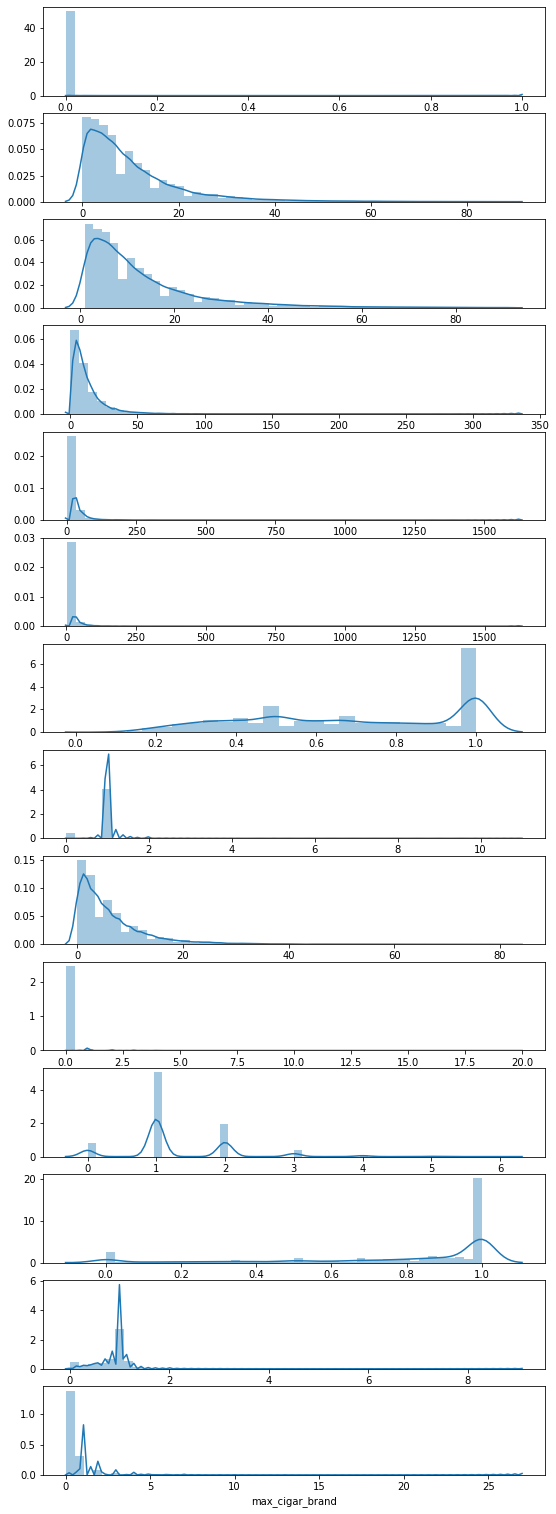

In [0]:
# plot histogram distribution for all variables
fig, axes = plt.subplots(14, figsize = (9,27))
for ax, col in zip(axes,data_viz.columns):
  sns.distplot(data_viz[col],ax=ax).set_xlabel(col)

In [0]:
# explore correlations
def show_correlations(df):
    corr = df.select_dtypes(include="number").corr()
    plt.subplots(figsize=(8,8));
    sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation matrix of all numerical features\n")
    plt.tight_layout()
    plt.show()

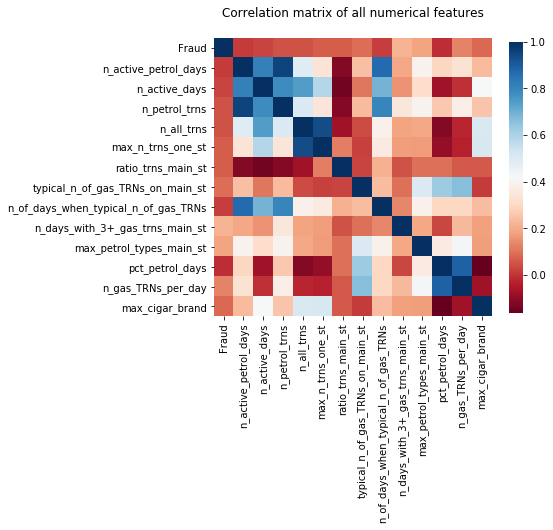

In [0]:
show_correlations(data_features.drop(["TRN_WAL_PERSON_ID", "TRN_WAL_WALLET", "main_petrol_st"], axis=1))

# Modeling


## Split data on test and train

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#drop id-like and fraud features
features = data_viz.drop("Fraud", axis=1).columns

X = data_features[features]
y = data_features["Fraud"]

X.head()

,n_active_petrol_days,n_active_days,n_petrol_trns,n_all_trns,max_n_trns_one_st,ratio_trns_main_st,typical_n_of_gas_TRNs_on_main_st,n_of_days_when_typical_n_of_gas_TRNs,n_days_with_3+_gas_trns_main_st,max_petrol_types_main_st,pct_petrol_days,n_gas_TRNs_per_day,max_cigar_brand
0,14.0,14,17.0,22,11,0.500000,1.0,6.0,0.0,3.0,1.000000,1.214286,0.0
1,14.0,18,17.0,24,4,0.166667,1.0,1.0,0.0,1.0,0.777778,0.944444,0.0
2,2.0,2,3.0,4,2,0.500000,1.0,1.0,0.0,1.0,1.000000,1.500000,0.0
3,23.0,23,24.0,37,36,0.972973,1.0,21.0,0.0,2.0,1.000000,1.043478,0.0
4,38.0,41,43.0,50,28,0.560000,1.0,24.0,0.0,1.0,0.926829,1.048780,0.0


0    21442
1       69
Name: Fraud, dtype: int64


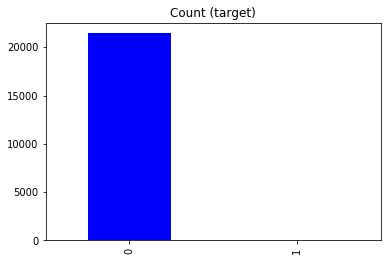

In [0]:
print(y.value_counts())
y.value_counts().plot(kind='bar', title='Count (target)', colors={'blue', 'orange'})

In [0]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
print(y_train.value_counts())
print(y_test.value_counts())

0    17153
1       55
Name: Fraud, dtype: int64
0    4289
1      14
Name: Fraud, dtype: int64


In [0]:
x_train.head()

,n_active_petrol_days,n_active_days,n_petrol_trns,n_all_trns,max_n_trns_one_st,ratio_trns_main_st,typical_n_of_gas_TRNs_on_main_st,n_of_days_when_typical_n_of_gas_TRNs,n_days_with_3+_gas_trns_main_st,max_petrol_types_main_st,pct_petrol_days,n_gas_TRNs_per_day,max_cigar_brand
15405,12.0,13,12.0,15,8,0.533333,1.0,7.0,0.0,1.0,0.923077,0.923077,0.0
15937,8.0,8,8.0,15,11,0.733333,1.0,5.0,0.0,1.0,1.000000,1.000000,0.0
5834,1.0,4,1.0,6,3,0.500000,0.0,0.0,0.0,0.0,0.250000,0.250000,0.0
13361,0.0,4,0.0,6,3,0.500000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
17315,6.0,6,6.0,6,5,0.833333,1.0,5.0,0.0,1.0,1.000000,1.000000,0.0


## Normalization

Normalization is used to give all the features (approximately)the same initial importance. It is useful in our case because our features often have different range. For example, total number of transactions is in range from 3 to 1500, and maximum number of different petrol types at the main station is usually around 3.

In [0]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train))
x_test = pd.DataFrame(ss.transform(x_test))

In [0]:
x_train.columns = X.columns
x_test.columns = X.columns

In [0]:
x_train.head()

,n_active_petrol_days,n_active_days,n_petrol_trns,n_all_trns,max_n_trns_one_st,ratio_trns_main_st,typical_n_of_gas_TRNs_on_main_st,n_of_days_when_typical_n_of_gas_TRNs,n_days_with_3+_gas_trns_main_st,max_petrol_types_main_st,pct_petrol_days,n_gas_TRNs_per_day,max_cigar_brand
0,0.174573,-0.017677,0.060370,-0.136472,-0.163138,-0.566258,0.260891,0.083466,-0.082739,-0.354705,0.435836,0.214710,-0.414327
1,-0.207246,-0.396965,-0.242657,-0.136472,-0.054527,0.190149,0.260891,-0.190659,-0.082739,-0.354705,0.686272,0.424373,-0.414327
2,-0.875429,-0.700396,-0.772954,-0.415630,-0.344157,-0.692326,-2.626194,-0.875972,-0.082739,-1.598338,-1.755482,-1.619842,-0.414327
3,-0.970883,-0.700396,-0.848711,-0.415630,-0.344157,-0.692326,-2.626194,-0.875972,-0.082739,-1.598338,-2.569400,-2.301248,-0.414327
4,-0.398155,-0.548680,-0.394170,-0.415630,-0.271749,0.568352,0.260891,-0.190659,-0.082739,-0.354705,0.686272,0.424373,-0.414327


## Balancing

As you have seen above, our dataset is highly imbalanced - 69 frauds out of almost 22000 users.

In [0]:
# searching for appropriate weights for the model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'class_weight': [{0: x, 1: 1.0-x} for x in weights]},
    scoring='f1',
    cv=5)
grid_result = gsc.fit(x_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)
x_train.shape

Best parameters : {'class_weight': {0: 0.23947368421052628, 1: 0.7605263157894737}}


(17208, 13)

# Supervised. Training

## Logistic Regression


### With automatically found weights

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
#Assign class weight to lower effect of class imbalance
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
class_weights_dict = dict(zip(np.unique(y),class_weights))

In [0]:
logit = LogisticRegression(class_weight = class_weights_dict)
logit.fit(x_train, y_train)

LogisticRegression(C=1.0,
                   class_weight={0: 0.5016089916985356, 1: 155.8768115942029},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

### With "GridSearched" class weights

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [0]:
# Modeling for GridSearchCV
lr_model_gsc = LogisticRegression(**grid_result.best_params_)

lr_model_gsc.fit(x_train, y_train)

LogisticRegression(C=1.0,
                   class_weight={0: 0.23947368421052628, 1: 0.7605263157894737},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

## Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features=10)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Text(0.5, 0, 'Relative importance')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, ' feature importance')

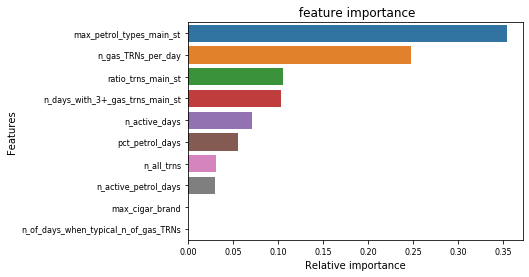

In [0]:
indices = np.argsort(dt_model.feature_importances_)[::-1][:10]
g = sns.barplot(y=x_train.columns[indices][:10],
                x = (dt_model.feature_importances_/(dt_model.feature_importances_.sum()))[indices][:10] , orient='h')
g.set_xlabel("Relative importance",fontsize=10)
g.set_ylabel("Features",fontsize=10)
g.tick_params(labelsize=8)
g.set_title(" feature importance")

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create decision tree classifer object
clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=grid_result.best_params_["class_weight"])

# Train model
model_fr = clf.fit(x_train, y_train)

Text(0.5, 0, 'Relative importance')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, ' feature importance')

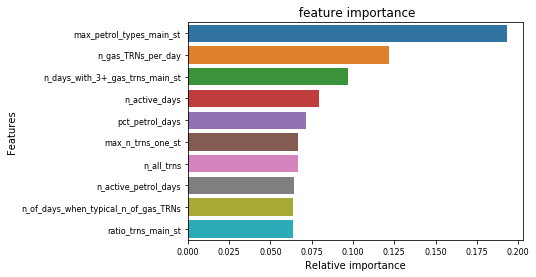

In [0]:
indices = np.argsort(model_fr.feature_importances_)[::-1][:10]
g = sns.barplot(y=x_train.columns[indices][:10],
                x = (model_fr.feature_importances_/(model_fr.feature_importances_.sum()))[indices][:10] , orient='h')
g.set_xlabel("Relative importance",fontsize=10)
g.set_ylabel("Features",fontsize=10)
g.tick_params(labelsize=8)
g.set_title(" feature importance")

 It is visible that the features that were advised by the client indeed play a significant role in distinguishing of frauds. Features related to different petrol transactions( especially at the main station) are the most improtant in both single Decision tree and Random forest.

# Dimensionality reduction

We have also tried dimensionality reduction approaches, in order to extract more distinguishable information. We even tried to predict the class using LDA.

## LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

## PCA

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [0]:
expl_var = np.sum(pca.explained_variance_ratio_)

print('2-component PCA explains {:.3f} of data!'.format(expl_var))

2-component PCA explains 0.964 of data!


As the 2-component PCA is capable of expaining almost all the variance in the data, we'll perform the clustering on it. This will make visualisation of results easier and more interpretable

# Save test dataset and models

In [0]:
import pickle

x_test_file = "xtest.csv"
y_test_file = "ytest.csv"
x_pca_file = "x_pca.csv"
y_file = "y.csv"

logit_file = "logit.sav"
lr_model_gsc_file = "lr_model.sav"
dt_model_file = "dt_model.sav"
model_fr_file = "clf.sav"
lda_model_file = "lda.sav"

pickle.dump(x_test, open(PATH+x_test_file, 'wb'))
pickle.dump(y_test, open(PATH+y_test_file, 'wb'))
pickle.dump(X_pca, open(PATH+x_pca_file, 'wb'))
pickle.dump(y, open(PATH+y_file, 'wb'))

pickle.dump(logit, open(PATH+logit_file, 'wb'))
pickle.dump(lr_model_gsc, open(PATH+lr_model_gsc_file, 'wb'))
pickle.dump(dt_model, open(PATH+dt_model_file, 'wb'))
pickle.dump(model_fr, open(PATH+model_fr_file, 'wb'))
pickle.dump(lda, open(PATH+lda_model_file, 'wb'))

-------------------------------------------------- REPRODUCIBLE PART ----------------------------------------------------

# Testing

In [0]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
x_test_file = "xtest.csv"
y_test_file = "ytest.csv"
x_pca_file = "x_pca.csv"
y_file = "y.csv"

logit_file = "logit.sav"
lr_model_gsc_file = "lr_model.sav"
dt_model_file = "dt_model.sav"
model_fr_file = "clf.sav"
lda_model_file = "lda.sav"

In [0]:
# specify your PATH
# PATH = "./drive/My Drive/AI_Project_Data/"

In [0]:
x_test = pickle.load(open(PATH+x_test_file, 'rb'))
y_test = pickle.load(open(PATH+y_test_file, 'rb'))
X_pca = pickle.load(open(PATH+x_pca_file, 'rb'))
y = pickle.load(open(PATH+y_file, 'rb'))

In [0]:
x_test.head()

,n_active_petrol_days,n_active_days,n_petrol_trns,n_all_trns,max_n_trns_one_st,ratio_trns_main_st,typical_n_of_gas_TRNs_on_main_st,n_of_days_when_typical_n_of_gas_TRNs,n_days_with_3+_gas_trns_main_st,max_petrol_types_main_st,pct_petrol_days,n_gas_TRNs_per_day,max_cigar_brand
0,-0.398155,-0.548680,-0.394170,-0.415630,-0.271749,0.568352,0.260891,-0.190659,-0.082739,2.132563,0.686272,0.424373,-0.414327
1,1.033666,0.665041,0.817938,0.514898,0.307511,-0.377156,0.260891,1.317029,-0.082739,-0.354705,0.538287,0.424373,-0.414327
2,-0.589065,-0.700396,-0.545684,-0.477665,-0.344157,0.253183,0.260891,-0.464785,-0.082739,-0.354705,0.686272,0.424373,-0.414327
3,-0.970883,-0.927968,-0.848711,-0.570718,-0.416565,1.198691,-2.626194,-0.875972,-0.082739,-1.598338,-2.569400,-2.301248,-0.414327
4,0.079118,-0.169392,-0.015386,-0.167489,-0.199342,-0.692326,0.260891,-0.190659,-0.082739,-0.354705,0.686272,0.424373,-0.414327


In [0]:
y_test.head()

1802     0
7154     0
9333     0
18890    0
612      0
Name: Fraud, dtype: int64

In [0]:
logit = pickle.load(open(PATH+logit_file, 'rb'))
lr_model_gsc = pickle.load(open(PATH+lr_model_gsc_file, 'rb'))
dt_model = pickle.load(open(PATH+dt_model_file, 'rb'))
model_fr = pickle.load(open(PATH+model_fr_file, 'rb'))
lda = pickle.load(open(PATH+lda_model_file, 'rb'))

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
def model_summary(y_test, y_pred):
  '''
  Shows the results of the supervised algorithm on th test set.
  Uses all metrices of our interest.
  '''
  plt.subplot()
  #Plot confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # Show the classification report
  print(classification_report(y_test,y_pred))    

In [0]:
from sklearn import metrics
def plot_roc_auc(model,x_test,y_test):
  '''
  Plots the ROC-AUC curve. 
  '''
  # Calculate the ROC_AUC characteristic
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  # Plot the curve
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4289
           1       0.05      0.86      0.10        14

    accuracy                           0.95      4303
   macro avg       0.53      0.90      0.54      4303
weighted avg       1.00      0.95      0.97      4303



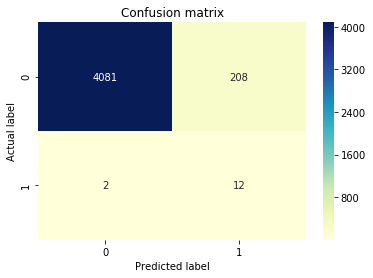

In [0]:
model_summary(y_test, logit.predict(x_test))

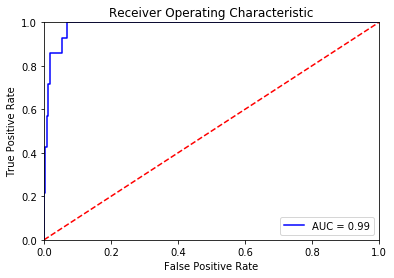

In [0]:
plot_roc_auc(logit, x_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4289
           1       0.55      0.43      0.48        14

    accuracy                           1.00      4303
   macro avg       0.77      0.71      0.74      4303
weighted avg       1.00      1.00      1.00      4303



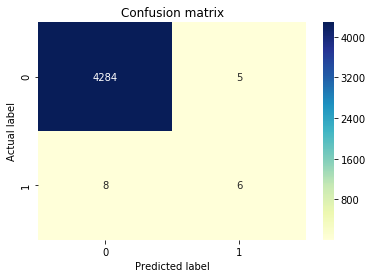

In [0]:
y_pred = lr_model_gsc.predict(x_test)

# Evaluate the model
model_summary(y_test, y_pred)

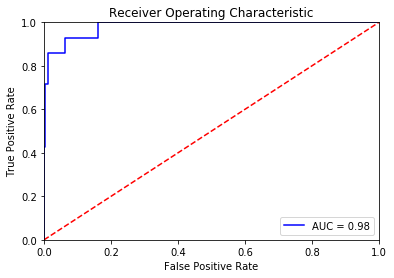

In [0]:
plot_roc_auc(lr_model_gsc, x_test, y_test)

The different results given by the models can be useful in different ways. 

For example, model 1 is giving 208 false positives (frauds which are not frauds) - among these could also be frauds who are not caught yet! So, if fraud detection is done manually (as it is now) or semi-manually, we can state that this model is a success: the worker has to check 208 suspicious users now, which is way faster and easier than ckecking all 4000!


---

Model 2 (with adjusted class weights) does not catch all frauds, but it doesn't give any false positive. This model performs better if the cost of a false positive is high - for example, if checking the video survelliance service to find the user is very difficult and costly. In such cases, it is better to have false negatives( to let the fraud go uncaught).


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4289
           1       1.00      0.21      0.35        14

    accuracy                           1.00      4303
   macro avg       1.00      0.61      0.68      4303
weighted avg       1.00      1.00      1.00      4303



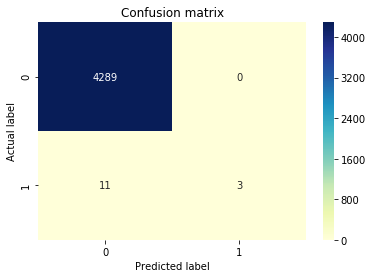

In [0]:
# Decision tree model
y_pred_dt= dt_model.predict(x_test)

# Evaluation
model_summary(y_test, y_pred_dt)

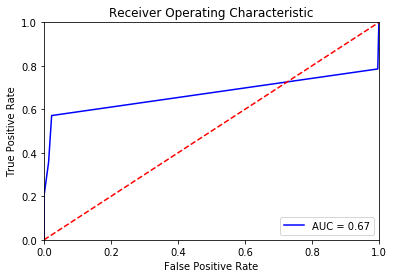

In [0]:
plot_roc_auc(dt_model, x_test, y_test)

The single decision tree is performing even more differently - we have 1 false positive as a result, and the number of false negatives have not changed since the second logistic regression. However, this model catches more true frauds.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4289
           1       0.80      0.29      0.42        14

    accuracy                           1.00      4303
   macro avg       0.90      0.64      0.71      4303
weighted avg       1.00      1.00      1.00      4303



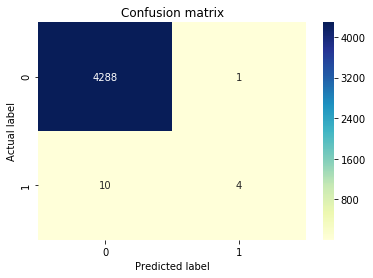

In [0]:
#Random Forest
y_rf_pred = model_fr.predict(x_test)
model_summary(y_test, y_rf_pred)

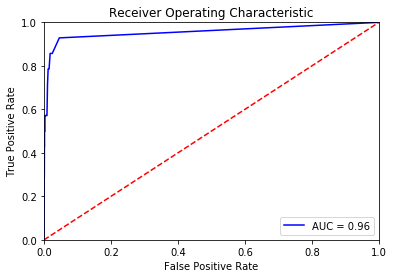

In [0]:
plot_roc_auc(model_fr, x_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4289
           1       0.32      0.50      0.39        14

    accuracy                           0.99      4303
   macro avg       0.66      0.75      0.69      4303
weighted avg       1.00      0.99      1.00      4303



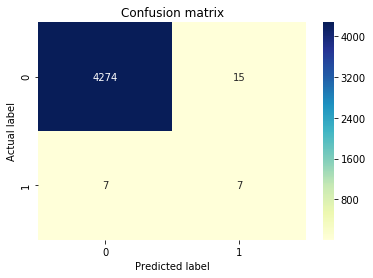

In [0]:
#LDA
y_pred_lda = lda.predict(x_test)
model_summary(y_test, y_pred_lda)

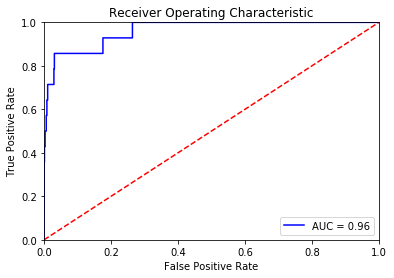

In [0]:
plot_roc_auc(lda, x_test, y_test)

LDA performs not bad as well.

# Unsupervised learning

## DBSCAN


In [0]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [0]:
# Search for best parameters
scores = []
models = []
max_score_dbscan = -1
eps_range = np.arange(1,8,0.5)
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples =10)
    dbscan.fit_predict(X_pca)
    try:
        score = silhouette_score(X_pca, dbscan.labels_)
    except ValueError:
        score = -1
    models.append(dbscan.get_params())
    if score  > max_score_dbscan:
        best_dbscan = dbscan 
        max_score_dbscan = score
    scores.append(score)
print(best_dbscan.get_params())

array([ 0,  0,  0, ..., -1, -1,  0])

array([ 0,  0,  0, ..., -1, -1,  0])

array([ 0,  0,  0, ..., -1, -1,  0])

array([ 0,  0,  0, ..., -1, -1,  0])

array([ 0,  0,  0, ...,  4, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

array([ 0,  0,  0, ...,  0, -1,  0])

{'algorithm': 'auto', 'eps': 7.0, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 10, 'n_jobs': None, 'p': None}


<Figure size 576x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f2983546978>,
 <a list of 14 Text xticklabel objects>)

<BarContainer object of 14 artists>

Text(0.5, 1.0, 'Silhouette score for model')

Text(0.5, 0, 'Epsilon')

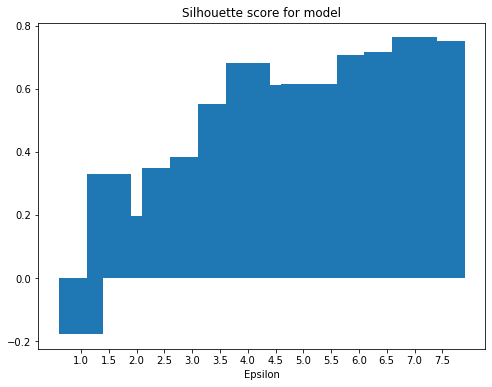

In [0]:
#Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.xticks(eps_range)
plt.bar(eps_range, scores)
plt.title('Silhouette score for model')
plt.xlabel('Epsilon')
plt.show()

In [0]:
clustering_res = pd.concat([pd.DataFrame(X_pca),y, pd.DataFrame(best_dbscan.labels_)], axis = 1)

In [0]:
clustering_res.columns =  ['x','y','Fraud','dbscan_cluster']

In [0]:
clustering_res

,x,y,Fraud,dbscan_cluster
0,2.390032,-6.196561,0,0
1,-0.032359,-8.997048,0,0
2,-22.636864,10.687323,0,0
3,33.895746,-13.043760,0,0
4,46.908860,-42.834816,0,0
...,...,...,...,...
21506,-12.865265,12.543551,1,0
21507,102.569486,-4.735263,1,0
21508,54.380398,6.599413,1,0
21509,226.568339,14.250257,1,-1


## GMM (Gaussian Mixture Model)

 To put it simply, GMM is simmilar to K-means in the way that it fits parameters to the data.
 The parameters of K-means are typically the cluster assignments ("z") and the means ("mu"). The parameters of a GMM are typically the means and variances (z and mu) as well as the class prior probabilities ("pi") and cluster covariances ("Sigma").

> 
GMM, unlike K-means, performs soft classification - it assigns the point to the class based on the probability that the point belongs to the class, whereas K-means assigns the class on the sole distance to the mean.
> 





In [0]:
from sklearn.mixture import GaussianMixture
import itertools
from numpy import linalg

In [0]:
def gridsearch_GMM(n_components_range, X_pca):
    '''
    Find the best number of components for the GMM model
    '''
    lowest_bic = np.infty
    bic = []
    
    n_components_range = range(1, 10)
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type='full')
        gmm.fit(X_pca)
        bic.append(gmm.bic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    bic = np.array(bic)
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14) #minimum BIC score is marked with an asterisk
    spl.set_xlabel('Number of components')
    #spl.legend([b[0] for b in bars])
    plt.bar(n_components_range,bic)
    plt.show()

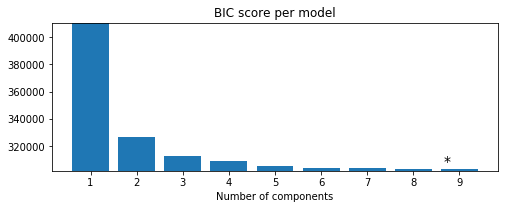

In [0]:
gridsearch_GMM(range(1, 10), X_pca)

After 4-component GMM model, BIC starts to decrease less rapidly. So, to avoid overfitting, I will use this number of clusters.

In [0]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'm', 'gold'])


def plot_results(X, Y_, means, covariances, index, title,score):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        plt.xlim(-50,500)
        plt.ylim(-200,600)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.title(title)


<Figure size 720x720 with 0 Axes>

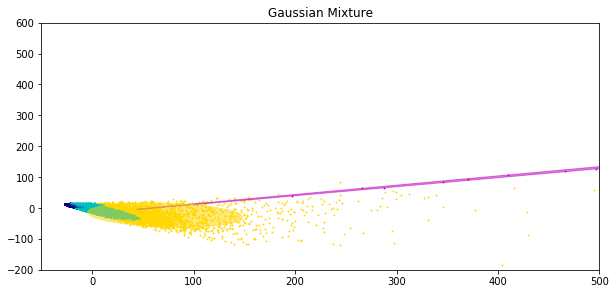

In [0]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X_pca)
plt.figure(figsize=(10,10))

# cropped the longest cluster a bit to see the distribution clearer
gmm_clusters = gmm.predict(X_pca)

plot_results(X_pca, gmm_clusters, gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture',gmm.score_samples(X_pca))
plt.show()    

In [0]:
clustering_res = pd.concat([clustering_res, pd.Series(gmm_clusters)], axis = 1)
clustering_res = clustering_res.rename(columns = {0:'gmm_cluster'})

# Cluster visualisation

In [0]:
def plot_2d_users( df, x, y, cluster=False):
  '''
  Plots 2d points as representation of users. Colors by clusters optionally
  Red crosses display fraud users.

  '''
  if cluster:
    palette = sns.cubehelix_palette(n_colors=df[cluster].nunique(), start=5, rot=0.6, gamma=1.0, hue=0.8, light=0.6, dark=0.1, reverse=False, as_cmap=False)
    hue = cluster
  else:
    palette = ["#000000","#ff0000"]
    hue = "Fraud"
  plt.figure(figsize=(12,10))
  sns.scatterplot(data = df, x=x, y=y, hue = hue, style="Fraud", size = "Fraud", size_order=[1,0] ,palette= palette, alpha = 0.8)
  plt.show()

### PCA

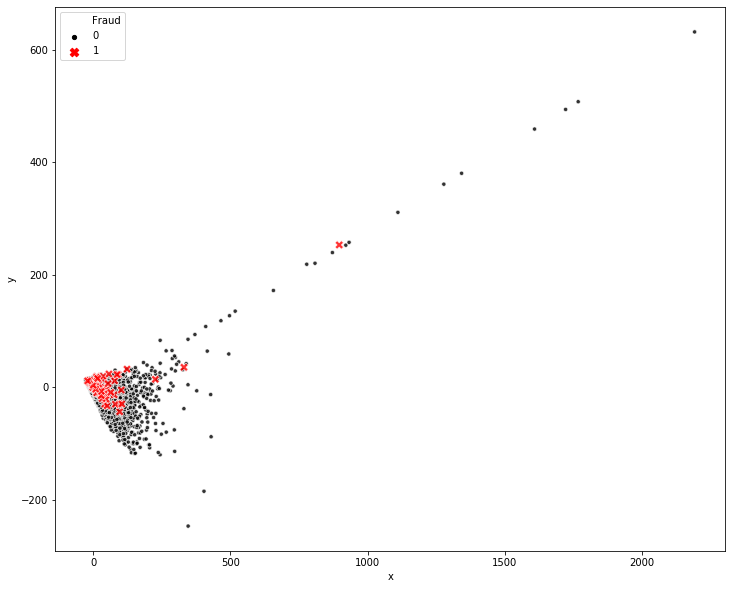

In [0]:
plot_2d_users(clustering_res, "x","y")

Frauds are pretty much gathered in one place, but so are the non-frauds(points that are not visible behind the red crosses)

# t-SNE

For the effective 2-D visualization of users' distribution, we used the t-Distributed Stochastic Neighbor Embedding technique, or t-SNE. It is particularly well suited for the visualization of high-dimensional datasets. 
>
As a rule of thumb: PCA tries to keep the faraway points in higher dimensions just as far in lower dimensions, while t-SNE keeps tha points that were near in the higher dimensions close together. We think that this is a more intuitive way to percieve the dataset, so we'll stick to the t-SNE.
>

Original paper on t-SNE can be found [here](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

### DBSCAN


In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,random_state = np.random.RandomState(seed=7))
tsne_results = tsne.fit_transform(X_pca)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21511 samples in 0.012s...
[t-SNE] Computed neighbors for 21511 samples in 0.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21511
[t-SNE] Computed conditional probabilities for sample 2000 / 21511
[t-SNE] Computed conditional probabilities for sample 3000 / 21511
[t-SNE] Computed conditional probabilities for sample 4000 / 21511
[t-SNE] Computed conditional probabilities for sample 5000 / 21511
[t-SNE] Computed conditional probabilities for sample 6000 / 21511
[t-SNE] Computed conditional probabilities for sample 7000 / 21511
[t-SNE] Computed conditional probabilities for sample 8000 / 21511
[t-SNE] Computed conditional probabilities for sample 9000 / 21511
[t-SNE] Computed conditional probabilities for sample 10000 / 21511
[t-SNE] Computed conditional probabilities for sample 11000 / 21511
[t-SNE] Computed conditional probabilities for sample 12000 / 21511
[t-SNE] Computed conditional probabilities for sa

In [0]:
tsne_coords =  pd.DataFrame(tsne_results, columns=["tsne_x",'tsne_y'])

In [0]:
clustering_res = pd.concat([clustering_res,tsne_coords], axis = 1)

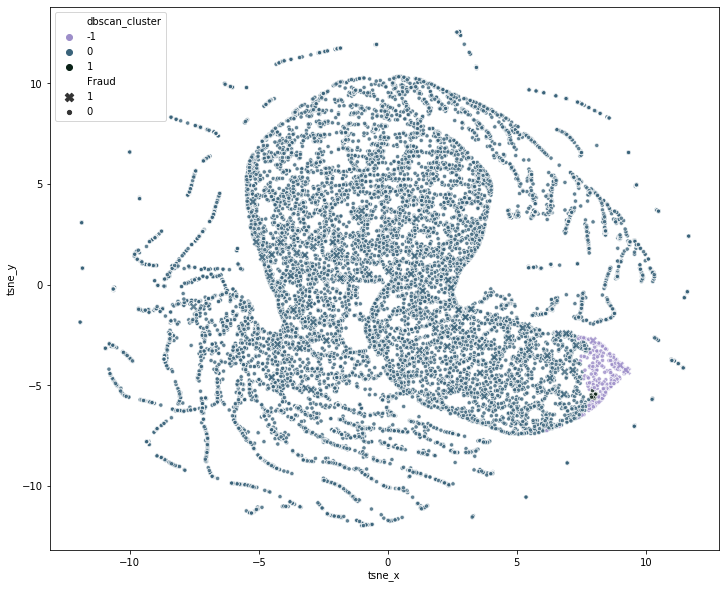

In [0]:
plot_2d_users(clustering_res, "tsne_x", "tsne_y", cluster="dbscan_cluster")

To see if any cluster can be called "the fraud cluster", look at the plot below:

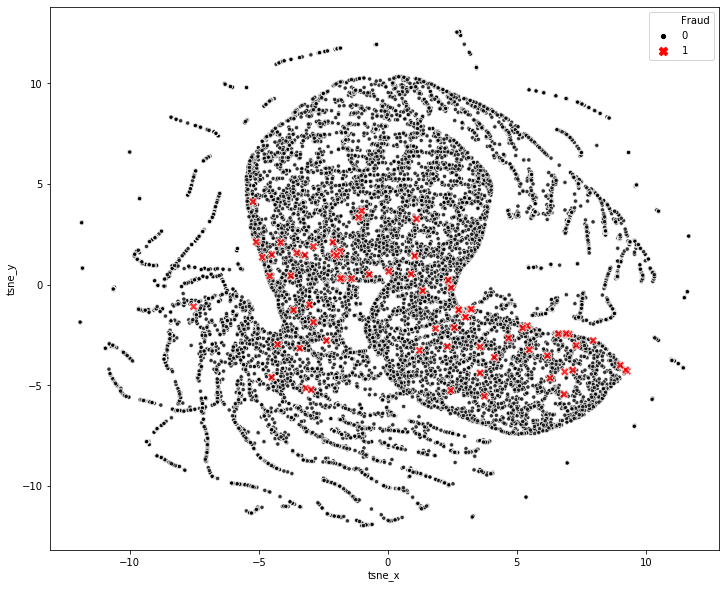

In [0]:
plot_2d_users(df= clustering_res, x="tsne_x", y="tsne_y")

## GMM

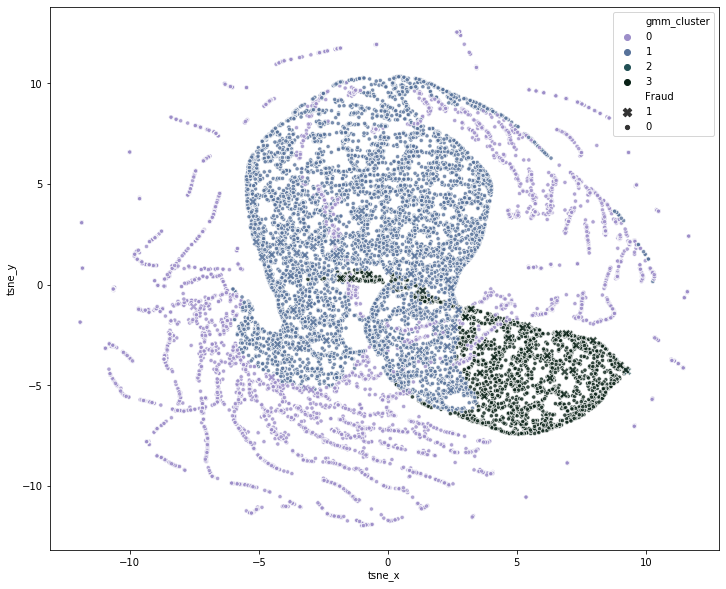

In [0]:
plot_2d_users(clustering_res, "tsne_x", "tsne_y", cluster="gmm_cluster")

# Cluster analysis

In [0]:
def percentage_frauds_in_cluster(df,cluster):
  '''
  Shows the summary of clusters n respect of their size and percentage of frauds in them
  '''

  colors = ['navy', 'c', 'm', 'gold']
  fig, ax = plt.subplots(3, figsize=(8,20))

  # Pie chart describing percentage size of each cluster
  plt.sca(ax[0])

  labels = df[cluster].unique()

  sizes = df.groupby(cluster).size()

  patches, texts, autotexts = plt.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.1, colors = colors)
  plt.title('Sizes of different {}'.format(cluster))
  plt.legend(patches, labels)



  # Draw fraud size percentage chart
  plt.sca(ax[1])
  fraud_sizes = df[df['Fraud'] == 1 ].groupby(cluster).size()
  patches, texts, autotexts =  plt.pie(fraud_sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.1, colors = colors)
  plt.title('Numbers of frauds in different {}'.format(cluster))
  plt.legend(patches, labels)


  ratio = fraud_sizes/sizes
  ratio.fillna(0, inplace = True)

  # Draw ratio of fraud to normal user in each cluster
  plt.sca(ax[2])
  plt.bar(x = ratio.index, height = ratio, tick_label = labels)
  plt.title('Ratio of frauds to regular in different {}'.format(cluster))
  
  plt.tight_layout()
  plt.show()

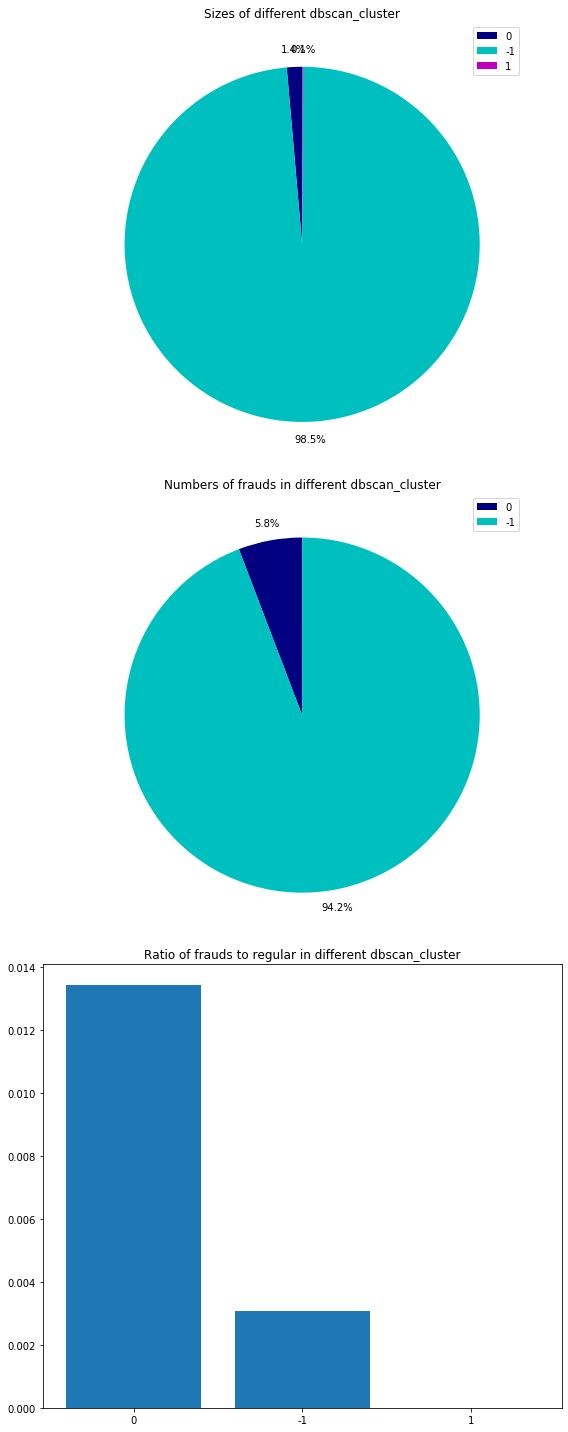

In [0]:
percentage_frauds_in_cluster(df=clustering_res,cluster="dbscan_cluster")

DBSCAN divides the data into 3 cluster,smallest of which has just a couple of users. Second smallest cluster has most frauds, but the ratio of frauds to normals is still very low - smaller than 0.015%
  

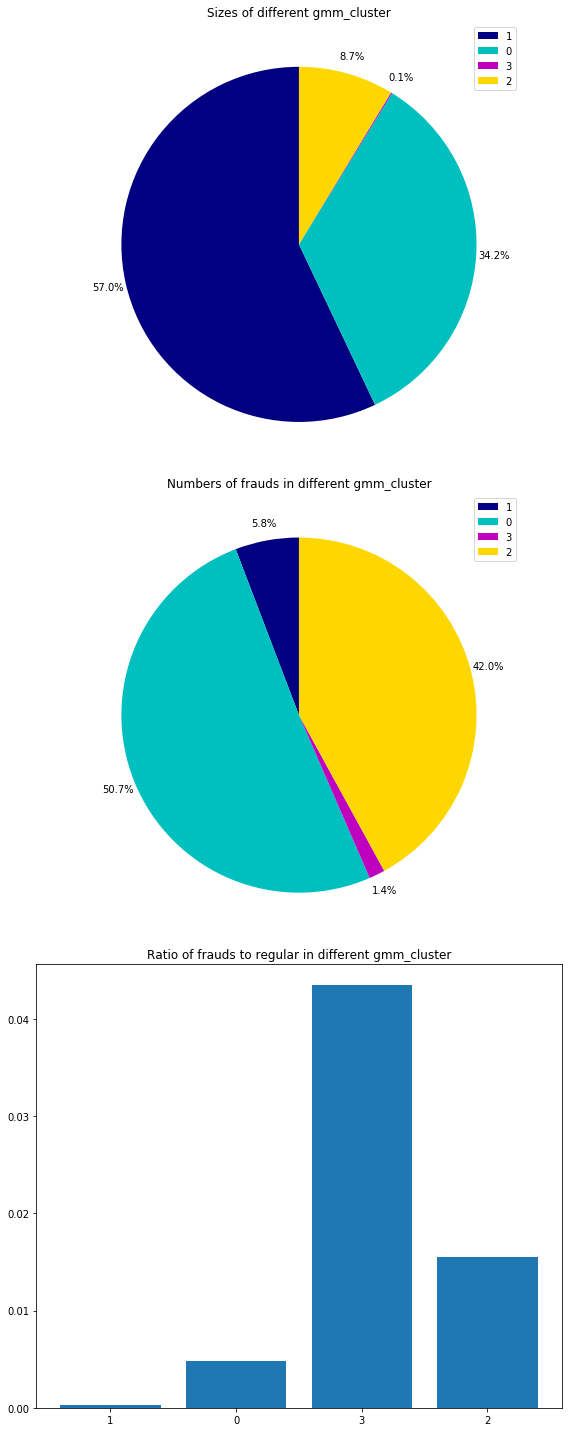

In [0]:
percentage_frauds_in_cluster(df=clustering_res,cluster="gmm_cluster")

# Warning: the colors of the pie clusters do not correspond with the colors
#of the ellipses on the GMM plot!

GMM gives slightly better results - although it divides data into more clusters, almost all frauds( 92% ) are in smaller clusters(9 percents of all users respectively). This increases the fraud-normal ratio up to 0.045%. This is still small, but we can work only with these clusters further on, narrowing our search subset massively.